Found 1280 images belonging to 4 classes.
Found 320 images belonging to 4 classes.
Found 800 images belonging to 4 classes.
Class Distribution in Training Data: {'Blotch_Apple': 320, 'Normal_Apple': 320, 'Rot_Apple': 320, 'Scab_Apple': 320}
Computed Class Weights: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0}


C:\Users\ASUS\AppData\Local\Temp\ipykernel_1812\3706204560.py:100: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 133s 14us/step
Epoch 1/50


C:\Users\ASUS\fyp\django-lms\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
C:\Users\ASUS\fyp\django-lms\venv\Lib\site-packages\PIL\Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 545ms/step - accuracy: 0.2678 - loss: 2.1717
Epoch 1: val_accuracy improved from -inf to 0.62187, saving model to best_model.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 39s 723ms/step - accuracy: 0.2696 - loss: 2.1642 - val_accuracy: 0.6219 - val_loss: 0.9652 - learning_rate: 1.0000e-04
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 586ms/step - accuracy: 0.5987 - loss: 1.0714
Epoch 2: val_accuracy improved from 0.62187 to 0.76562, saving model to best_model.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 31s 703ms/step - accuracy: 0.5991 - loss: 1.0708 - val_accuracy: 0.7656 - val_loss: 0.6805 - learning_rate: 1.0000e-04
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 733ms/step - accuracy: 0.6650 - loss: 0.9101
Epoch 3: val_accuracy improved from 0.76562 to 0.79688, saving model to best_model.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 38s 855ms/step - accuracy: 0.6657 - loss: 0.9086 - val_accuracy: 0.7969 - val_loss: 0.5747 - learning_rate: 1.0000e-04
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 669ms/step

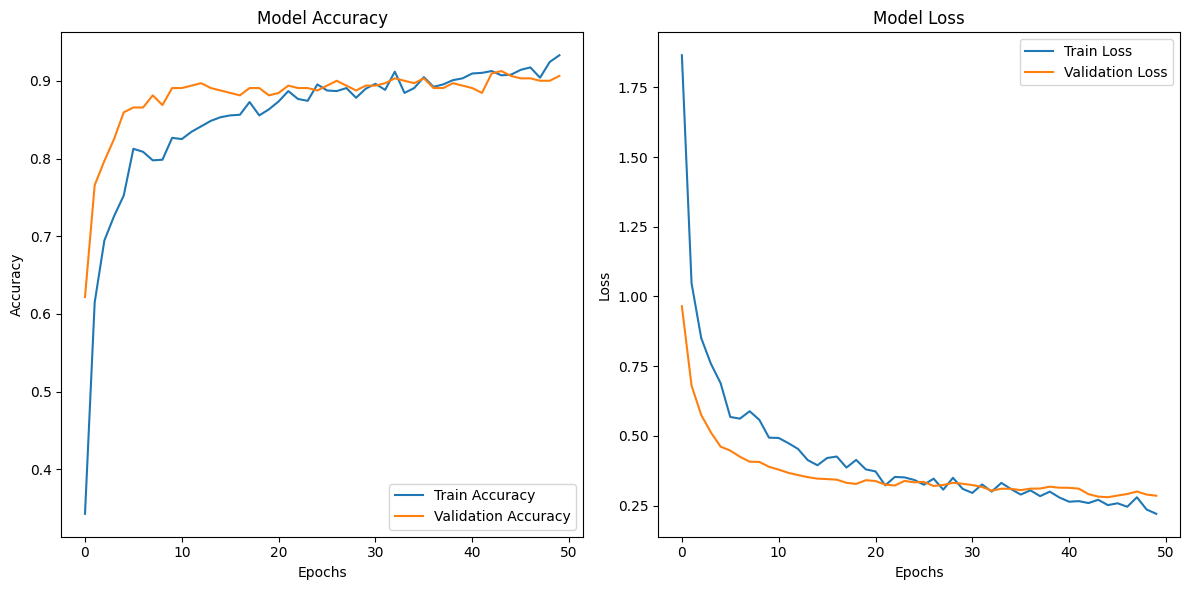

25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 430ms/step - accuracy: 0.9081 - loss: 0.3028
Test Loss: 0.2762695252895355
Test Accuracy: 0.9049999713897705


In [2]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import os
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight

# Define the path to your dataset folders
base_dir = r'C:\Users\ASUS\OneDrive\Desktop\fyp2\datasets\apple_disease_classification'
train_dir = os.path.join(base_dir, 'Train_Split')
val_dir = os.path.join(base_dir, 'Validation_Split')
test_dir = os.path.join(base_dir, 'Test')

# Centralized augmentation settings
def create_datagen(rescale=1./255, augment=False):
    if augment:
        return ImageDataGenerator(
            rescale=rescale,
            rotation_range=30,
            width_shift_range=0.2,
            height_shift_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            brightness_range=[0.8, 1.2],  # Adjust brightness
            shear_range=0.2              # Add shear transformation
        )
    return ImageDataGenerator(rescale=rescale)

# Data Augmentation and Image Preprocessing
train_datagen = create_datagen(augment=True)
val_datagen = create_datagen()
test_datagen = create_datagen()

# Load training and validation data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

# Load test data
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

# Compute class weights to handle imbalance
actual_class_distribution = {class_name: count for class_name, count in zip(train_generator.class_indices.keys(), np.bincount(train_generator.classes))}
print(f"Class Distribution in Training Data: {actual_class_distribution}")

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))
print(f"Computed Class Weights: {class_weights}")

# Callbacks for training
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=30,  # Increased patience to allow more training before stopping
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,  # Reduce learning rate by factor of 5
    patience=30,  # Increased patience to avoid premature reductions
    min_lr=1e-7,
    verbose=1
)

# Build the CNN Model using transfer learning
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base_model.trainable = False  # Freeze the base model

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.0001)),  # Reduced dense layer size
    BatchNormalization(),
    Dropout(0.3),
    Dense(4, activation='softmax')  # 4 output classes
])

# Compile the Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the Model
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[early_stopping, model_checkpoint, reduce_lr],
    class_weight=class_weights
)

# Plot training and validation metrics
plt.figure(figsize=(12, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Save the plot for tracking performance
plt.tight_layout()
plt.savefig('training_validation_metrics.png')
plt.show()

# Evaluate the Model on Test Data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
